In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import seaborn as sns
sns.set(color_codes=True)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.projected_flights LIMIT 10000;")

In [3]:
fetch_batch_size = 1000

la_times = [300,600,1200]
alt_dct  = {}
spd_dct = {}
hdg_dct = {}

for la in la_times:
    alt_dct[str(la)] = {}
    hdg_dct[str(la)] = {}
    spd_dct[str(la)] = {}
    
    alt_dct[str(la)]['vals'] = []
    hdg_dct[str(la)]['vals'] = []
    spd_dct[str(la)]['vals'] = []

while True:
    
    batch = cur_read.fetchmany(size=fetch_batch_size)
    
    if not batch:
        break
    
    for f in batch:
        fdf = pd.DataFrame.from_dict(f)
        for i,la in enumerate(la_times):
            if i==0:
                alt_dct[str(la)]['vals'].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['alt'][0])
                spd_dct[str(la)]['vals'].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['spd'][0])
                hdg_dct[str(la)]['vals'].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['hdg'][0])
            else:
                alt_dct[str(la)]['vals'].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['alt'][0])
                spd_dct[str(la)]['vals'].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['spd'][0])
                hdg_dct[str(la)]['vals'].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['hdg'][0])
        

for la in la_times:
    alt_dct[str(la)]['var'] = np.nanstd(alt_dct[str(la)]['vals'])
    alt_dct[str(la)]['mean'] = np.nanmean(alt_dct[str(la)]['vals'])
    alt_dct[str(la)]['kurt'] = stats.kurtosis(alt_dct[str(la)]['vals'])
    alt_dct[str(la)]['skew'] = stats.skew(alt_dct[str(la)]['vals'])
    
    spd_dct[str(la)]['var'] = np.nanstd(spd_dct[str(la)]['vals'])
    spd_dct[str(la)]['mean'] = np.nanmean(spd_dct[str(la)]['vals'])
    spd_dct[str(la)]['kurt'] = stats.kurtosis(spd_dct[str(la)]['vals'])
    spd_dct[str(la)]['skew'] = stats.skew(spd_dct[str(la)]['vals'])
    
    hdg_dct[str(la)]['var'] = np.nanstd(hdg_dct[str(la)]['vals'])
    hdg_dct[str(la)]['mean'] = np.nanmean(hdg_dct[str(la)]['vals'])
    hdg_dct[str(la)]['kurt'] = stats.kurtosis(hdg_dct[str(la)]['vals'])
    hdg_dct[str(la)]['skew'] = stats.skew(hdg_dct[str(la)]['vals'])

In [72]:
for la in la_times:
    print(alt_dct[str(la)]['skew'])

1.8502944786934175
1.000017471904486
0.6523810824999094
0.22846243861276888
0.12646952706727024


/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


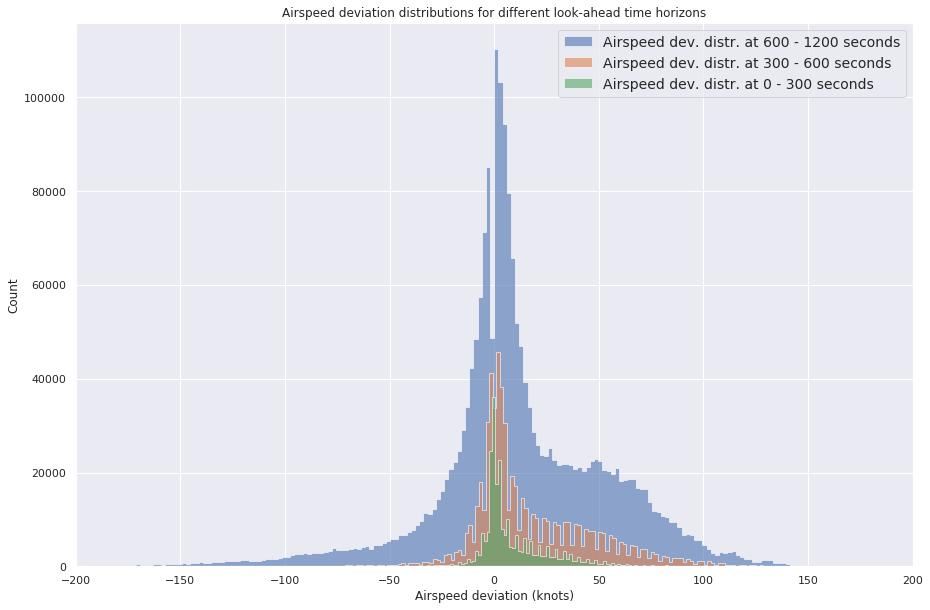

In [22]:
from matplotlib import mlab
np.random.seed(0)
fig, ax = plt.subplots(figsize=(15, 10))
range_lim = 200
dct = spd_dct

for i,la in enumerate(la_times[::-1]):

    la_lst = la_times[::-1] + [0]
    xtst = [x for x in dct[str(la)]['vals'] if ~np.isnan(x) and abs(x) < range_lim]
#     xtst_stdz = (xtst-np.mean(xtst))/np.std(xtst)
    n_bins = 200

    # plot the cumulative histogram
    n, bins, patches = ax.hist(xtst, n_bins, normed=0, histtype='stepfilled',
                               cumulative=False, label='Airspeed dev. distr. at %s - %s seconds' % (la_lst[i+1], la), alpha=0.6)
    
#     plt.xlabel('')
plt.legend(prop={'size': 14})
# plt.xlim(-200,200)
# plt.ylim(0,100000)
plt.xlabel('Airspeed deviation (knots)')
plt.ylabel('Count')
plt.title('Airspeed deviation distributions for different look-ahead time horizons')
plt.show()

No handles with labels found to put in legend.


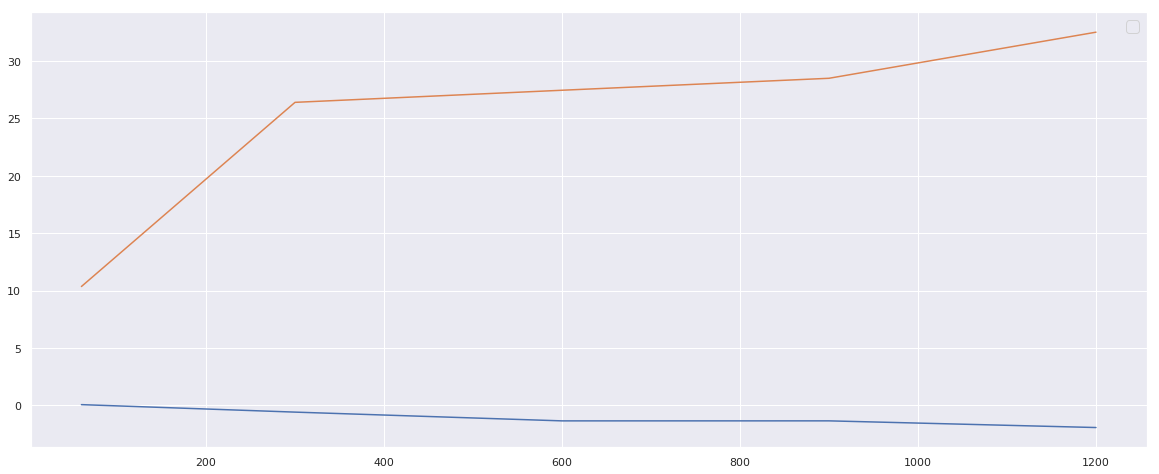

In [76]:
plt.figure(figsize=(20,8))
plt.plot(la_times, [hdg_dct[str(la)]['mean'] for la in la_times])
plt.plot(la_times, [hdg_dct[str(la)]['var'] for la in la_times])
# plt.plot(la_times, [alt_dct[str(la)]['skew'] for la in la_times])
# plt.plot(la_times, [alt_dct[str(la)]['kurt'] for la in la_times])
plt.legend(prop={'size': 16})
plt.show()

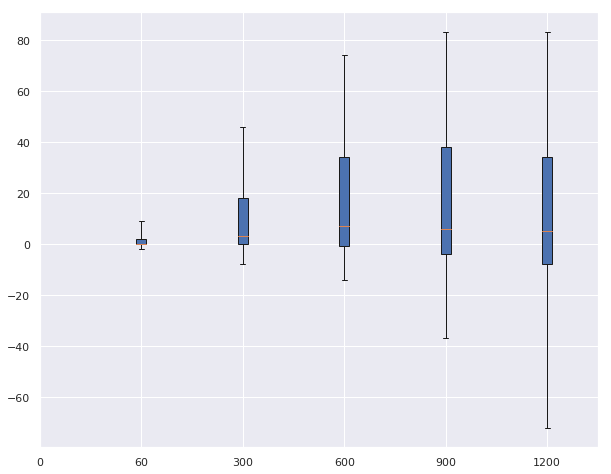

In [79]:
box_data = []
dct = spd_dct

for la in la_times:
    box_data.append((la, [i for i in dct[str(la)]['vals'] if ~np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2)+1)

plt.figure(figsize=(10,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95], widths = 0.1)
plt.xticks(x, ['0','60','300', '600', '900', '1200'])
# plt.xticks(rotation=70)
# plt.xlabel('Look-ahead time (seconds)')
# plt.ylabel('ATE in meters')
# plt.title('Evolution of ATE over look-ahead time')
# plt.legend(prop={'size': 16})
# plt.xlim((0,600))
plt.show()

In [31]:
df = pd.DataFrame()

df['spd'] = spd_dct['300']['vals']
df['alt'] = alt_dct['300']['vals']
df['hdg'] = hdg_dct['300']['vals']

spd_std = (df['spd']-np.mean(df['spd']))/np.std(df['spd'])
hdg_std = (df['hdg']-np.mean(df['hdg']))/np.std(df['hdg'])
alt_std = (df['alt']-np.mean(df['alt']))/np.std(df['alt'])

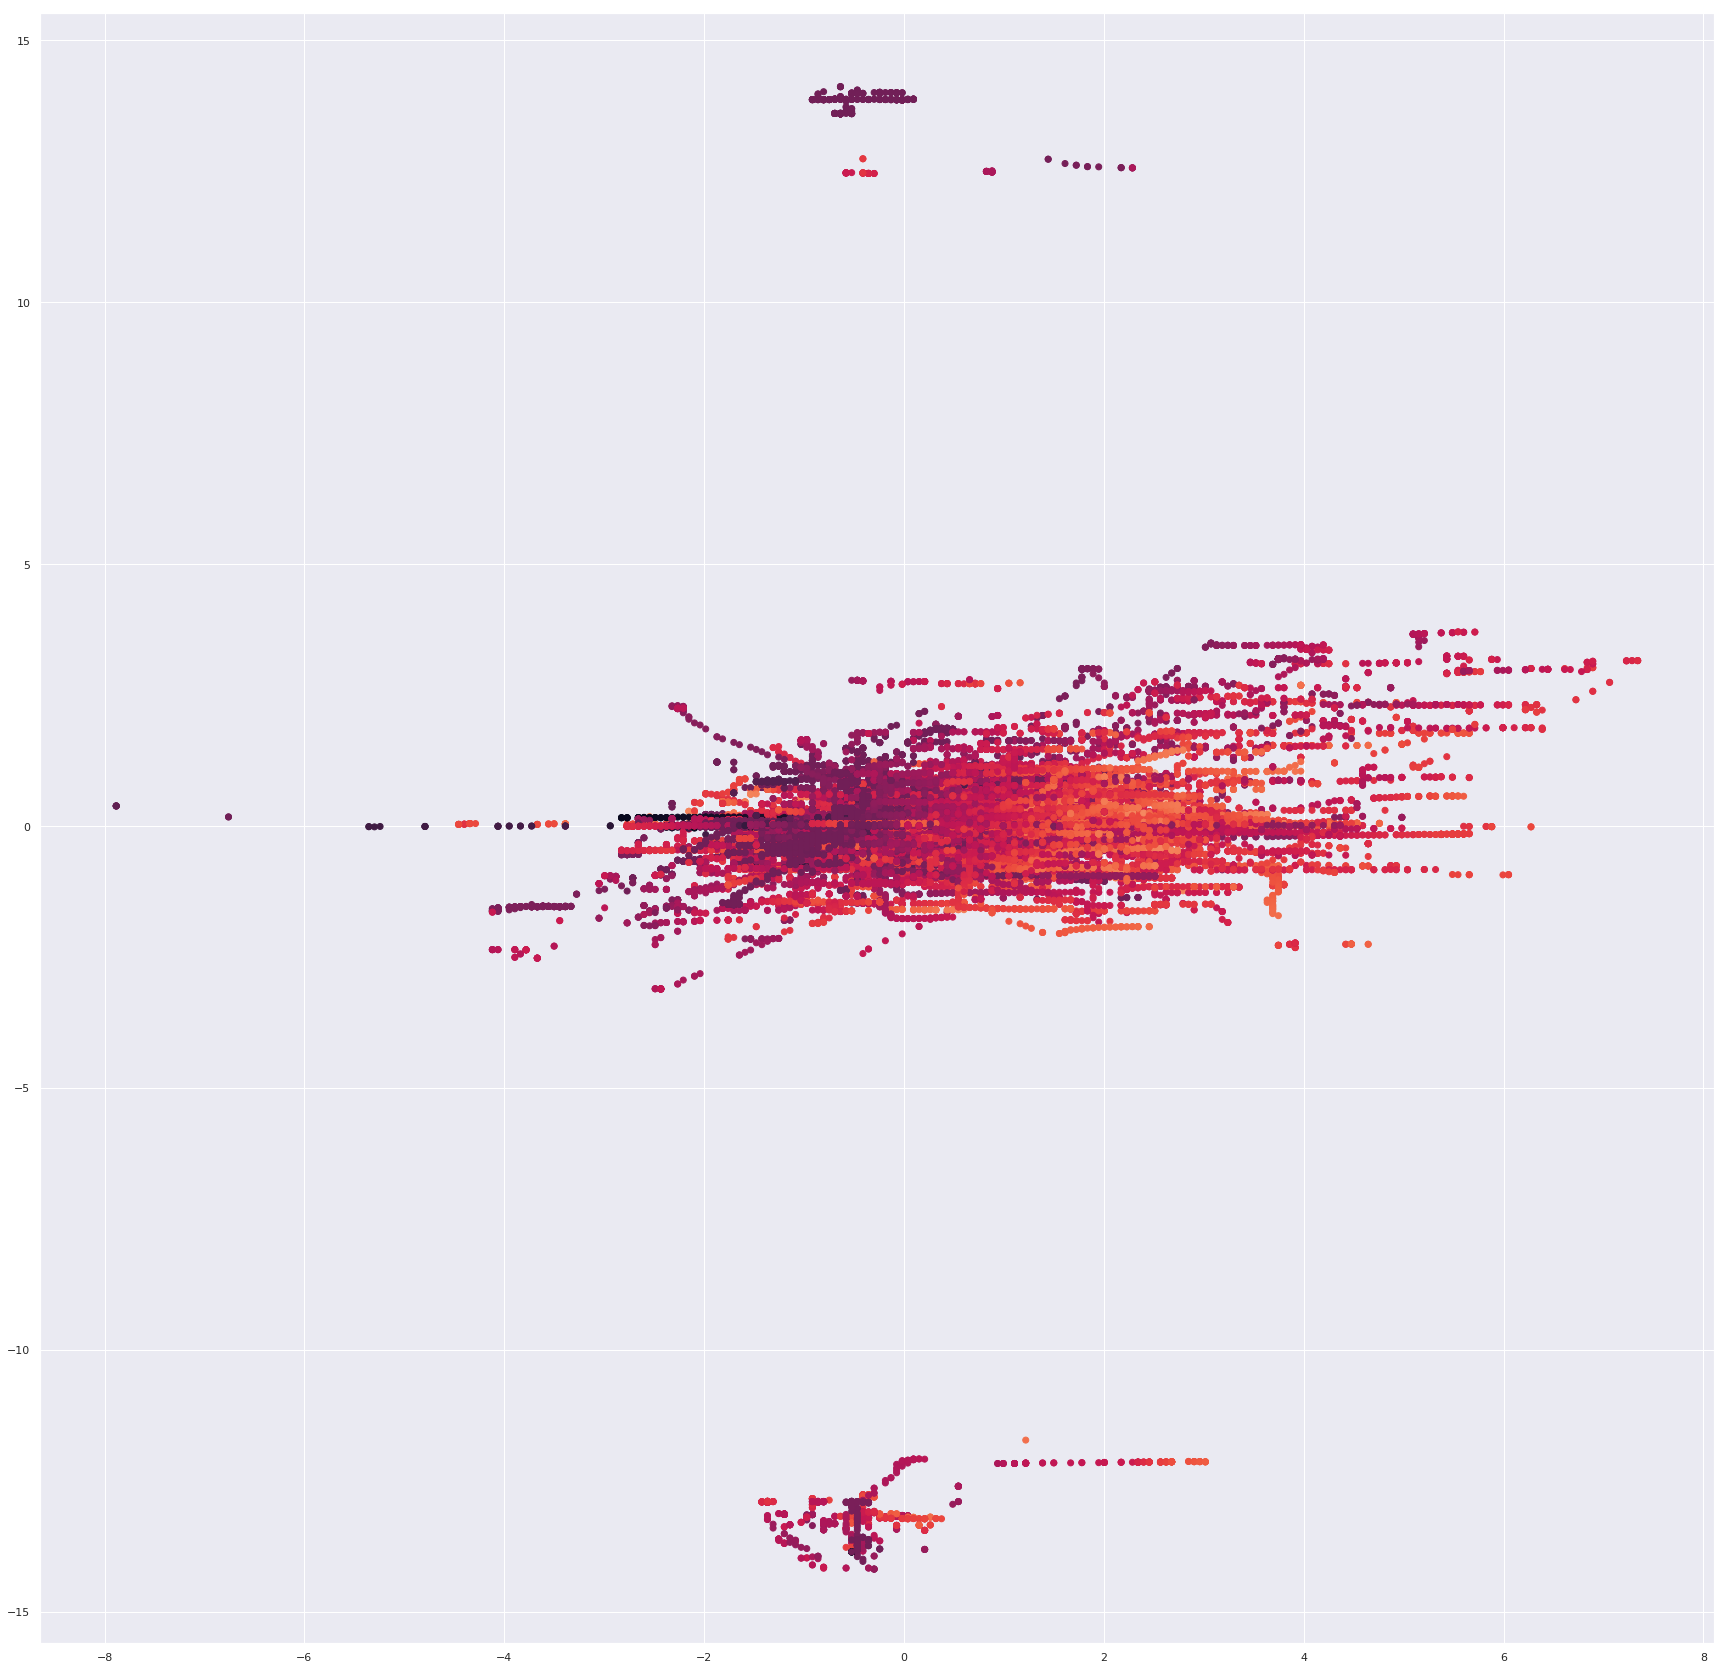

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(30,30))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df['spd'], df['alt'], df['hdg'])
plt.scatter(spd_std, hdg_std, c=alt_std)

# plt.set_xlabel('Airspeed')
# plt.set_ylabel('Altitude')
# plt.set_zlabel('Heading')

plt.show()

In [107]:
la_times[::-1] + [0]

[1200, 600, 300, 0]

In [79]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

max_inserts = 100
fetch_batch_size = max_inserts
cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.projected_flights LIMIT 1000;")

fetch_batch_size = 1000

la_times = [5*x for x in range(1,121)]
alt_dct_2  = {}
spd_dct_2 = {}
hdg_dct_2 = {}

for la in la_times:
    alt_dct_2[str(la)] = []
    hdg_dct_2[str(la)] = []
    spd_dct_2[str(la)] = []

while True:
    
    batch = cur_read.fetchmany(size=fetch_batch_size)
    
    if not batch:
        break
    
    for f in batch:
        fdf = pd.DataFrame.from_dict(f)
        for i,la in enumerate(la_times):
            if i==0:
                alt_dct_2[str(la)].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['alt'][0])
                spd_dct_2[str(la)].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['spd'][0])
                hdg_dct_2[str(la)].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= 0)].values - fdf['hdg'][0])
            else:
                alt_dct_2[str(la)].extend(fdf['alt'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['alt'][0])
                spd_dct_2[str(la)].extend(fdf['spd'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['spd'][0])
                hdg_dct_2[str(la)].extend(fdf['hdg'][(fdf['time_el'] <= la) & (fdf['time_el'] >= la_times[i-1])].values - fdf['hdg'][0])

cur_read.close()
conn.close()

In [80]:
acf = []
acf_t = []
dct = hdg_dct_2
for i,la in enumerate(la_times):
    
    if i > 0:
        
        x = [v for v in dct[str(la_times[0])] if ~np.isnan(v)]
        y = [v for v in dct[str(la)] if ~np.isnan(v)]
        print(len(x))
        print(len(y))
        acf.append(est_cr(x,y))
        acf_t.append(la)

17
140
17
236
17
307
17
335
17
339
17
324
17
315
17
323
17
317
17
306
17
359
17
371
17
352
17
374
17
369
17
372
17
372
17
393
17
413
17
443
17
415
17
422
17
451
17
480
17
493
17
503
17
491
17
508
17
498
17
534
17
575
17
550
17
533
17
575
17
572
17
537
17
568
17
580
17
612
17
633
17
649
17
651
17
695
17
696
17
662
17
685
17
687
17
640
17
638
17
660
17
676
17
697
17
771
17
742
17
761
17
711
17
790
17
789
17
830
17
780
17
792
17
783
17
822
17
829
17
835
17
910
17
874
17
946
17
948
17
1000
17
978
17
1022
17
1031
17
1015
17
1036
17
1058
17
1018
17
1069
17
1074
17
1100
17
1066
17
1143
17
1087
17
1160
17
1156
17
1153
17
1148
17
1143
17
1165
17
1149
17
1173
17
1143
17
1166
17
1152
17
1189
17
1194
17
1178
17
1150
17
1179
17
1199
17
1194
17
1184
17
1229
17
1188
17
1219
17
1246
17
1242
17
1260
17
1238
17
1278
17
1250
17
1220
17
1336
17
1258
17
1333
17
1344
17
1342
17
1380
17
1324


/home/victor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [52]:
x = [1,2,3,2,3,2,3,2,3]
n = len(x)
x = x-np.mean(x)
np.correlate(x,x, mode='full')[-n:]

array([ 4.        , -1.11111111,  0.77777778, -0.66666667,  0.22222222,
       -0.22222222, -0.33333333,  0.22222222, -0.88888889])

In [66]:
def est_acr(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return r

def est_cr(x,y):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = min(len(x),len(y))
    x = x[:n]
    y = y[:n]
    xstd = np.std(x)
    ystd = np.std(y)
    x = x-np.mean(x)
    y = y-np.mean(y)
    r = np.dot(x,y)/(n-1)
    result = r/(xstd*ystd)
    return result

In [58]:
est_acr(x)

array([ 4.        , -1.11111111,  0.77777778, -0.66666667,  0.22222222,
       -0.22222222, -0.33333333,  0.22222222, -0.88888889])

In [49]:
x

array([-1.,  0.,  1.])

In [60]:
np.arange(3,0,-1)

array([3, 2, 1])

In [67]:
est_cr([1,2,3,4,5,6],[3,4,3,4,3,4,5,5,5])

0.35132402626147197

In [71]:
dct.keys()

dict_keys(['300', '600', '1200'])

In [81]:
acf

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [85]:
x = [v for v in dct['50'] if ~np.isnan(v)]
y = [v for v in dct['60'] if ~np.isnan(v)]
print(len(x))
print(len(y))
acf.append(est_cr(x,y))

317
359


In [86]:
acf

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8141481707763407]